In [30]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/llorg/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import get_value, set_value
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

In [29]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce RTX 3090

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [2]:
sns.axes_style()
sns.set_style("white")
sns.set_context("notebook", rc={'axes.labelsize': 12.0, 'axes.titlesize': 14.0, 'legend.fontsize': 12.0, 'xtick.labelsize': 12.0, 'ytick.labelsize': 12.0})
sns.set_palette("deep")

In [3]:
nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
mask_root = nsd_root + "nsddata/ppdata/"

subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
# timestamp = 'May-03-2021_0134'
timestamp = 'May-04-2021_0340'
# timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'gabor_fwrf'

root_dir   = os.path.dirname(os.getcwd())
net_dir    = root_dir + "net/" 

# input_dir  = '/home/styvesg/repo.data/results/nsd/torch_fwrf_full_brain/S%02d/dnn_fwrf_May-10-2020_1814/'
output_dir = os.path.join(root_dir, 'gabor_model_fits','S%02d'%subject,'%s_%s/'% (model_name,timestamp) )

In [4]:
# Loading the results of model fitting performed with fit_model.py

fns = os.listdir(output_dir)
print(fns)
out = torch.load(os.path.join(output_dir, fns[0]))
print(out.keys())

aperture = out['aperture']
cyc_per_stim  = out['cyc_per_stim']
orients_deg = out['orients_deg']

sf_tuning_masks = out['tuning_masks']
ori_tuning_masks = out['ori_tuning_masks']

voxel_mask = out['voxel_mask']
brain_nii_shape = out['brain_nii_shape']
image_order = out['image_order']
voxel_idx = out['voxel_index']
voxel_roi = out['voxel_roi']

val_cc = out['val_cc']
best_params = out['best_params']
best_lambdas = out['best_lambdas']
best_losses = out['best_losses']
lambdas = out['lambdas']

partition_cc_sf = out['partition_val_sf']
partition_cc_ori = out['partition_val_orient']

# Best params[0] = x,y,sigma for pRF estimates [n_voxels x 3]
print(np.shape(best_params[0]))
# Best params[1] = best weights [n_voxels x nFeatures]
print(np.shape(best_params[1]))

best_models = best_params[0]
best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

feature_weights = best_params[1]

n_sf = len(cyc_per_stim)
n_ori = len(orients_deg)
n_voxels = np.shape(feature_weights)[0]
n_features_total = np.shape(feature_weights)[1]

['model_params_allROIs', 'val_cc.nii', 'rf_ecc.nii', 'rf_ang.nii', 'rf_size.nii']
dict_keys(['lmask', 'fmask', 'tuning_masks', 'ori_tuning_masks', 'cyc_per_stim', 'orients_deg', 'aperture', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'best_params', 'lambdas', 'best_lambdas', 'val_cc', 'best_losses', 'partition_val_sf', 'partition_val_orient'])
(11694, 3)
(11694, 432)


In [13]:
# ori_tuning_masks[0]

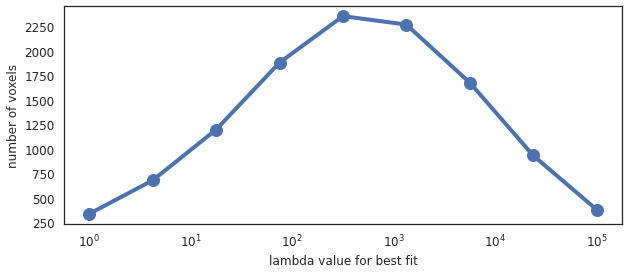

In [5]:
# Plot best lambda values for all voxels

plt.figure(figsize=(10,4))
lambdas = np.logspace(0.,5.,9, dtype=np.float32)
plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log');
plt.xlabel('lambda value for best fit');
plt.ylabel('number of voxels');

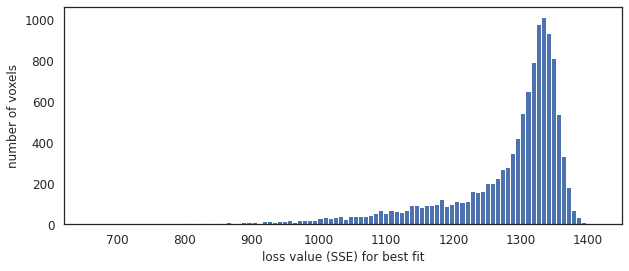

In [6]:
# Plot best loss values for all voxels

plt.figure(figsize=(10,4))
plt.hist(best_losses,100)
plt.xlabel('loss value (SSE) for best fit');
plt.ylabel('number of voxels');

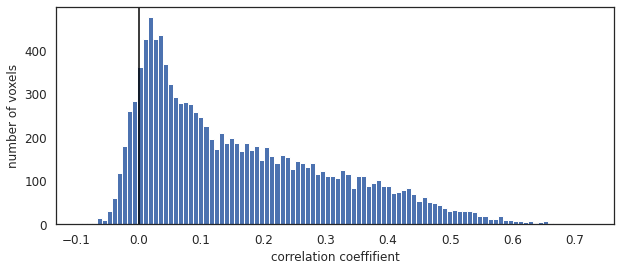

In [7]:
# Plot correlation coefficient for validation set, each voxel.

plt.figure(figsize=(10,4))
plt.hist(val_cc,100)
plt.xlabel('correlation coeffifient');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')


Text(0, 0.5, 'validation set rho')

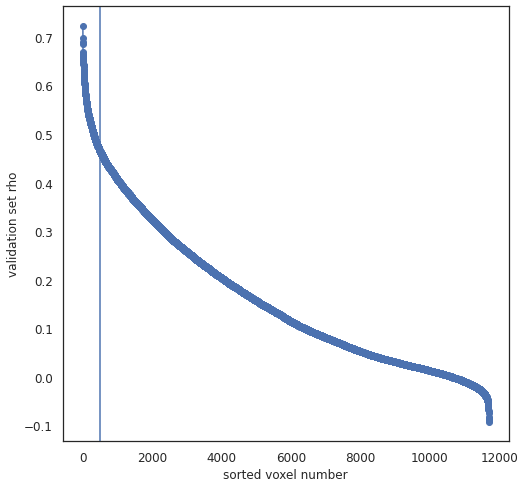

In [8]:
# Plot sorted correlation coefficients

plt.figure(figsize=(8,8))
# best_cc_vals = np.argsort(val_cc)
plt.plot(np.sort(val_cc)[::-1],'-o')
plt.axvline(500)
plt.xlabel('sorted voxel number')
plt.ylabel('validation set rho')

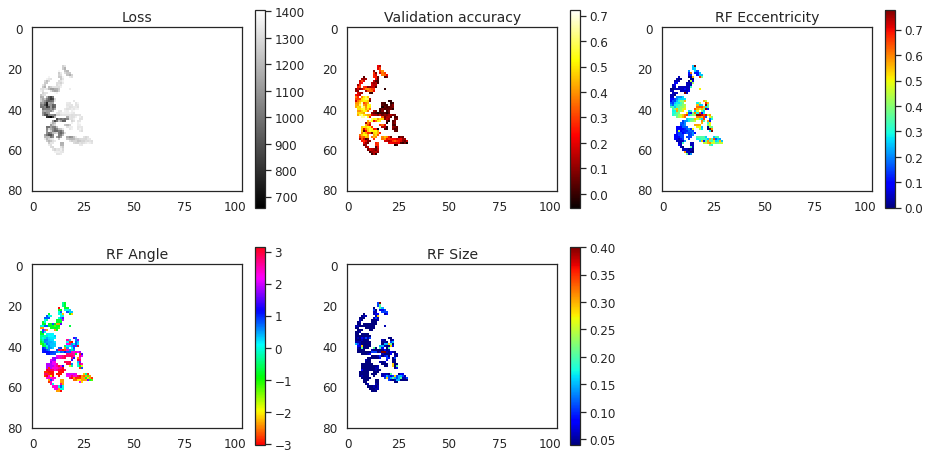

In [48]:
# Visualize some basic properties of pRFs for each voxel, in volume space
# Should be sanity check for dorsal/visual distinctions, esp w/r/t RF angle estimates

from src.file_utility import view_data

volume_loss = view_data(brain_nii_shape, voxel_idx, best_losses)
volume_cc   = view_data(brain_nii_shape, voxel_idx, val_cc, save_to=output_dir+"val_cc")
volume_ecc  = view_data(brain_nii_shape, voxel_idx, best_ecc, save_to=output_dir+"rf_ecc")
volume_ang  = view_data(brain_nii_shape, voxel_idx, best_ang, save_to=output_dir+"rf_ang")
volume_size = view_data(brain_nii_shape, voxel_idx, best_size, save_to=output_dir+"rf_size")

slice_idx = 40
fig = plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('Loss')
plt.imshow(volume_loss[:,:,slice_idx], cmap='gray', interpolation='None')
plt.colorbar()
plt.subplot(2,3,2)
plt.title('Validation accuracy')
plt.imshow(volume_cc[:,:,slice_idx], cmap='hot', interpolation='None')
plt.colorbar()
plt.subplot(2,3,3)
plt.title('RF Eccentricity')
plt.imshow(volume_ecc[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(2,3,4)
plt.title('RF Angle')
plt.imshow(volume_ang[:,:,slice_idx], cmap='hsv', interpolation='None')
plt.colorbar()
plt.subplot(2,3,5)
plt.title('RF Size')
plt.imshow(volume_size[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

In [16]:
# Assessing spatial frequency and orientation tuning

# based on "partition val" which are the correlation coefficients for models including 
# just the features corresponding to each SF or orient (one value at a time)
max_sf_cc_ind = np.argmax(partition_cc_sf, axis=0)
preferred_sf_cc = cyc_per_stim[max_sf_cc_ind]

max_ori_cc_ind = np.argmax(partition_cc_ori, axis=0)
preferred_ori_cc = orients_deg[max_ori_cc_ind]

# Can also look at tuning by taking value of weights in learned model.

allw_reshaped = np.reshape(feature_weights, [n_voxels, n_ori, n_sf], order='F')

mean_orient_weights = np.mean(allw_reshaped, axis=2)
print(np.shape(mean_orient_weights))
mean_sf_weights = np.mean(allw_reshaped, axis=1)
print(np.shape(mean_sf_weights))

max_orient_weight_ind = np.argmax(mean_orient_weights, axis=1)
preferred_ori_weights = orients_deg[max_orient_weight_ind]

max_sf_weight_ind = np.argmax(mean_sf_weights, axis=1)
preferred_sf_weights = cyc_per_stim[max_sf_weight_ind]


(11694, 36)
(11694, 12)


In [11]:
# double check that the reshaping was done correctly
sf=0
oo=0
print(allw_reshaped[0,:,sf])
print(feature_weights[0,sf_tuning_masks[sf]])

print(allw_reshaped[0,oo,:])
print(feature_weights[0,ori_tuning_masks[oo]])

[-1.6575872e-03 -4.2962225e-04  1.1515114e-03  2.1680566e-03
  2.8423113e-03  2.8121891e-03  2.4515144e-03  1.4204476e-03
  1.1493345e-03  1.3675479e-03  9.8663918e-04 -1.5561236e-05
 -6.7072024e-04  2.2270140e-04 -4.6733575e-04 -2.3397342e-03
 -4.7386140e-03 -5.1594265e-03 -4.5271115e-03 -3.9896630e-03
 -3.4889055e-03 -2.3622150e-03 -8.2030799e-04  8.2735583e-04
  1.4318617e-03  1.4265691e-03  1.9399886e-03  1.3958724e-03
  1.3616427e-03  1.9832721e-03  2.0306231e-03  1.4849517e-03
  6.0799188e-04  2.7018273e-04 -5.3166359e-04 -1.7866003e-03]
[-1.6575872e-03 -4.2962225e-04  1.1515114e-03  2.1680566e-03
  2.8423113e-03  2.8121891e-03  2.4515144e-03  1.4204476e-03
  1.1493345e-03  1.3675479e-03  9.8663918e-04 -1.5561236e-05
 -6.7072024e-04  2.2270140e-04 -4.6733575e-04 -2.3397342e-03
 -4.7386140e-03 -5.1594265e-03 -4.5271115e-03 -3.9896630e-03
 -3.4889055e-03 -2.3622150e-03 -8.2030799e-04  8.2735583e-04
  1.4318617e-03  1.4265691e-03  1.9399886e-03  1.3958724e-03
  1.3616427e-03  1.9832

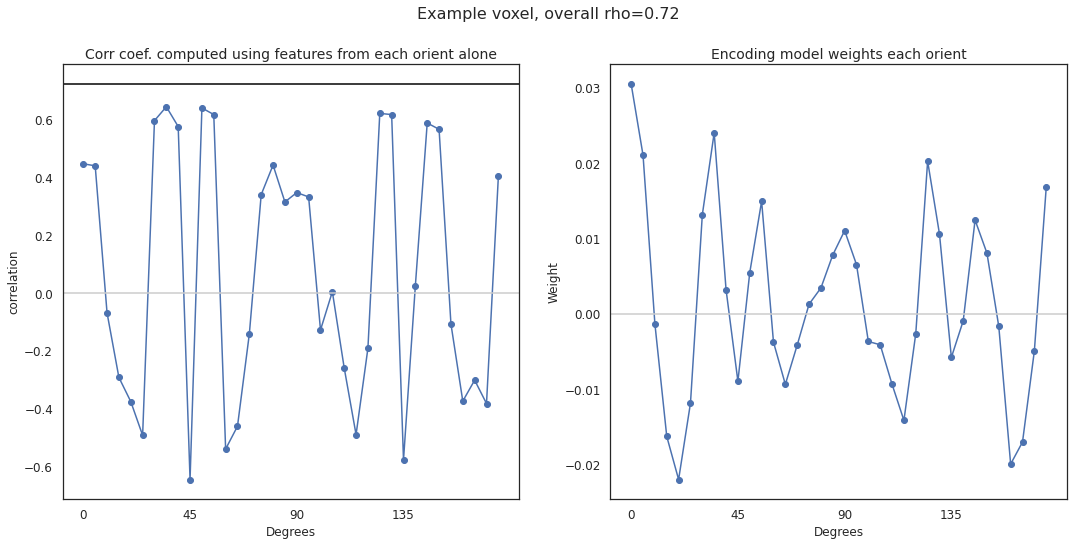

In [14]:
# Plotting tuning for one example voxel

vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance

plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(orients_deg, partition_cc_ori[:,vidx],'-o')
plt.xlabel('Degrees')
plt.ylabel('correlation')
plt.title('Corr coef. computed using features from each orient alone')
plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))

plt.subplot(1,2,2)
# plt.plot(orients_deg, allw_reshaped[vidx,4,:])
plt.plot(orients_deg, mean_orient_weights[vidx,:],'-o')
plt.xlabel('Degrees')
plt.ylabel('Weight')
plt.title('Encoding model weights each orient')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))

plt.suptitle('Example voxel, overall rho=%.2f'%(val_cc[vidx]),fontsize=16);

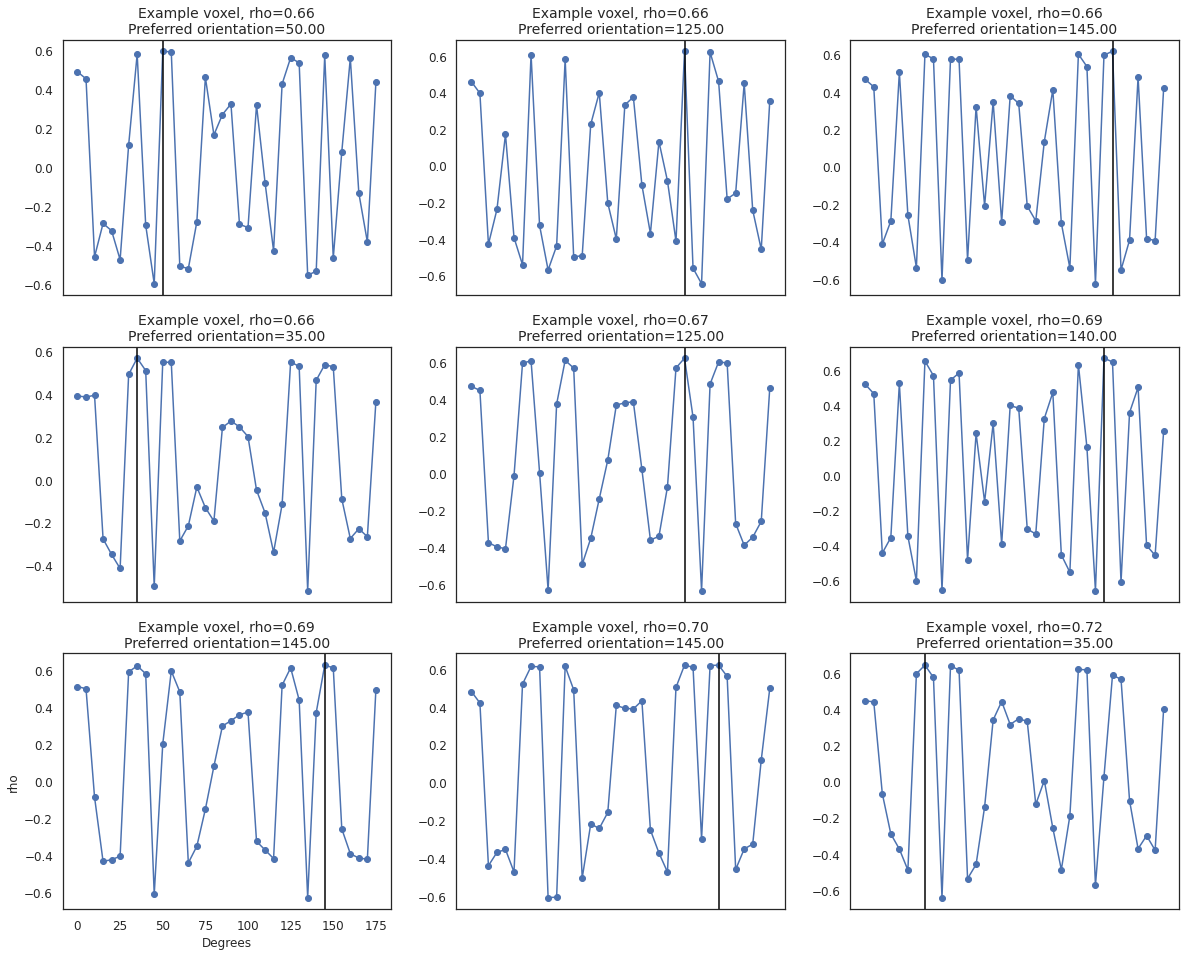

In [17]:
# Plotting tuning for several example voxels.
n2plot = 9
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    plt.plot(orients_deg, partition_cc_ori[:,vv], '-o')    
    plt.axvline(preferred_ori_cc[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('Degrees')
        plt.ylabel('rho')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    plt.title('Example voxel, rho=%.2f\nPreferred orientation=%.2f'%(val_cc[vv], preferred_ori_cc[vv]))


([<matplotlib.axis.XTick at 0x7fab09a16ac8>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

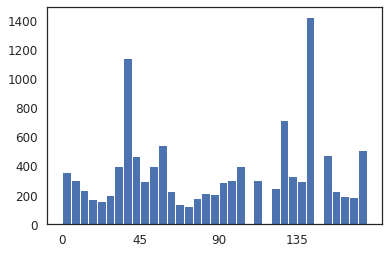

In [18]:
# Plot histogram of the "tuning preferences" based on partition correlation coefficient
plt.figure()
plt.hist(preferred_ori_cc, bins=np.arange(0,180,5));
plt.xticks(np.arange(0,179,45))

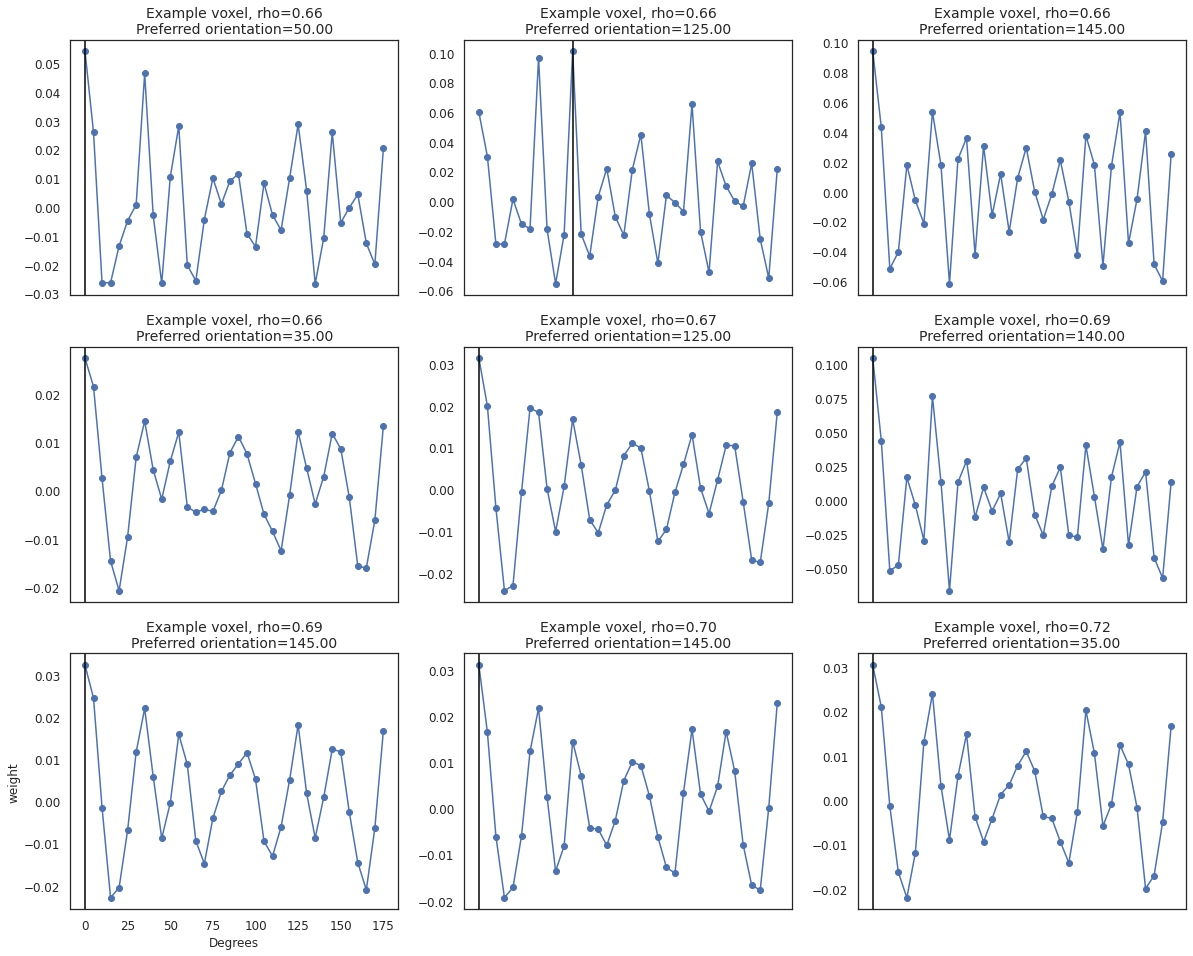

In [49]:
# Plotting tuning for several example voxels.
n2plot = 9
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    plt.plot(orients_deg, mean_orient_weights[vv,:], '-o')    
    plt.axvline(preferred_ori_weights[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('Degrees')
        plt.ylabel('weight')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    plt.title('Example voxel, rho=%.2f\nPreferred orientation=%.2f'%(val_cc[vv], preferred_ori_cc[vv]))


([<matplotlib.axis.XTick at 0x7fab09945a20>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

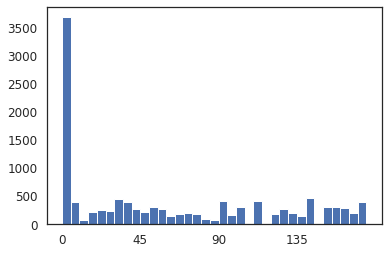

In [19]:
# Plot histogram of the "tuning preferences" based on encoding model weights
plt.figure()
plt.hist(preferred_ori_weights, bins=np.arange(0,180,5));
plt.xticks(np.arange(0,179,45))

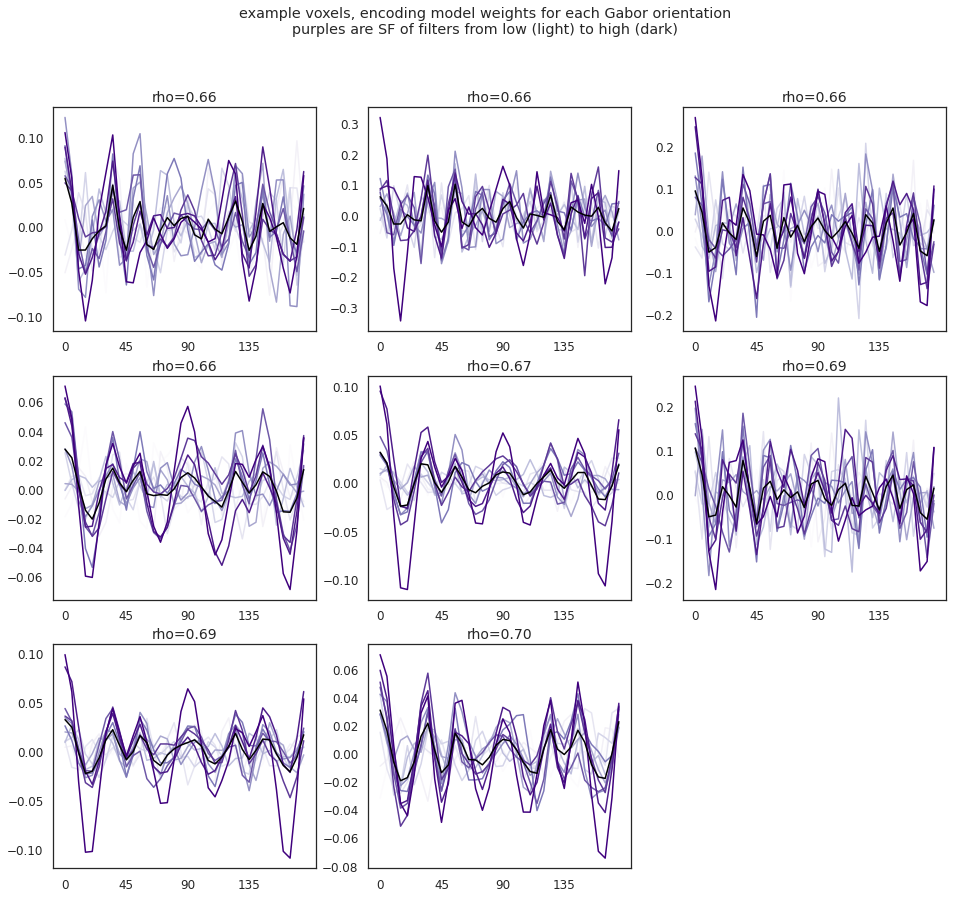

In [22]:
# Plotting weights profile over orientation, for some example voxels 
# light gray are individual SFs, dark gray is best SF (based on variance partitioning)
# black is mean of weights across SFs

n2plot = 9
vox2plot = np.argsort(val_cc)[-n2plot:-1]
# vox2plot = np.random.randint(0, len(val_cc), n2plot)
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

sf_colors = cm.Purples(np.linspace(0,1,n_sf))

plt.figure(figsize=(16,14))
for vi, vv in enumerate(vox2plot):
        
    plt.subplot(npx, npy, vi+1)
    
    for sf in range(n_sf):
        plt.plot(orients_deg, allw_reshaped[vv,:,sf],color=sf_colors[sf,:])
#     best_sf = preferred_ori_weights[vv]
#     plt.plot(orients_deg, allw_reshaped[vv,:,best_sf],color=[0.5, 0.5, 0.5])
    plt.plot(orients_deg, mean_orient_weights[vv,:],'k')
    plt.xticks(np.arange(0,179,45))
    plt.title('rho=%.2f'%val_cc[vv])
    
plt.suptitle('example voxels, encoding model weights for each Gabor orientation\npurples are SF of filters from low (light) to high (dark)');

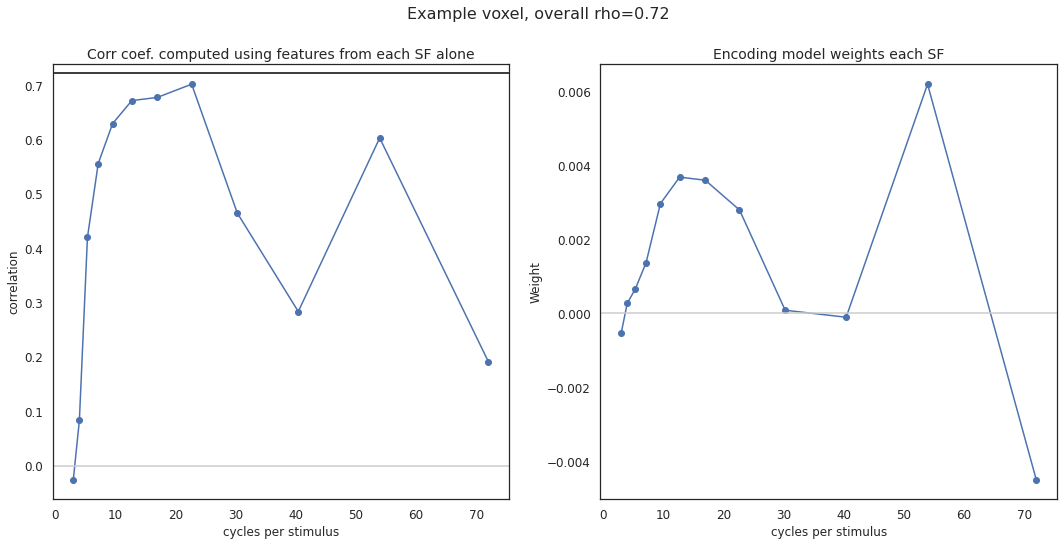

In [23]:
# Plotting SF tuning for one example voxel

vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance

plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(cyc_per_stim, partition_cc_sf[:,vidx],'-o')
plt.xlabel('cycles per stimulus')
plt.ylabel('correlation')
plt.title('Corr coef. computed using features from each SF alone')
plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])

plt.subplot(1,2,2)
plt.plot(cyc_per_stim, mean_sf_weights[vidx,:],'-o')
plt.xlabel('cycles per stimulus')
plt.ylabel('Weight')
plt.title('Encoding model weights each SF')
plt.axhline(0, color=[0.8, 0.8, 0.8])

plt.suptitle('Example voxel, overall rho=%.2f'%(val_cc[vidx]),fontsize=16);

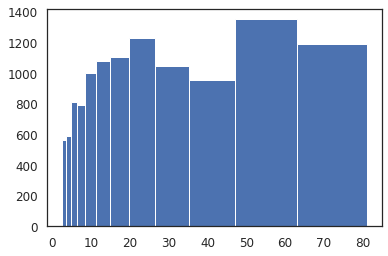

In [24]:
# Plot histogram of the "tuning preferences" based on partition correlation coefficient

better_bin_edges = [cyc_per_stim[ii] - np.diff(cyc_per_stim[ii-1:ii+1])/2 for ii in np.arange(1,len(cyc_per_stim))]
better_bin_edges.insert(0, cyc_per_stim[0] - np.diff(cyc_per_stim[0:2])/2)
better_bin_edges.append(cyc_per_stim[-1] + np.diff(cyc_per_stim[-2:])/2)
better_bin_edges = np.squeeze(better_bin_edges)

unvals, counts = np.unique(preferred_sf_cc, return_counts=True)

plt.figure()
h = plt.hist(preferred_sf_cc, bins=better_bin_edges);


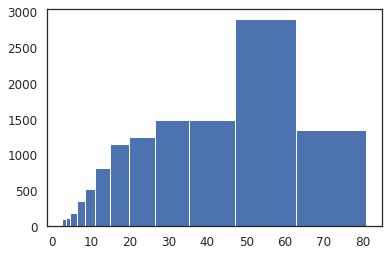

In [25]:
# Plot histogram of the "tuning preferences" based on encoding model weights

plt.figure()
h = plt.hist(preferred_sf_weights, bins=better_bin_edges);
unvals, counts = np.unique(preferred_sf_weights, return_counts=True)


In [26]:
# Load some voxel data to do some more testing...

beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"
exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)

from src.load_nsd import load_betas
voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask, up_to=10, load_ext=".nii")
print (voxel_data.shape)

# Loading images to do some more testing...

exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

from src.load_nsd import image_uncolorize_fn, data_split

# Setting up training/testing splits...

n_trials, n_voxels = voxel_data.shape 
trn_stim_data, trn_voxel_data,\
val_stim_single_trial_data, val_voxel_single_trial_data,\
val_stim_multi_trial_data, val_voxel_multi_trial_data = \
    data_split(image_uncolorize_fn(image_data), voxel_data, ordering, imagewise=False)

/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.271, <sigma> = 1.348
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.136, <sigma> = 1.238
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.332, <sigma> = 1.340
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.064, <sigma> = 1.225
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.225, <sigma> = 1.385
/lab_data/tarrl

In [31]:
# Setting up the feature extractor w gabor filter bank

from src.torch_fwrf import get_value, set_value, _to_torch
from src.gabor_feature_extractor import Gaborizer
from src.rf_grid import linspace, logspace

class add_nonlinearity(torch.nn.Module):
    def __init__(self, _fmaps_fn, _nonlinearity):
        super(add_nonlinearity, self).__init__()
        self.fmaps_fn = _fmaps_fn
        self.nl_fn = _nonlinearity
    def forward(self, _x):
        return [self.nl_fn(_fm) for _fm in self.fmaps_fn(_x)]

n_ori = 36
n_sf = 12
# cyc_per_stim = logspace(12)(3., 72.) # 6-92
cyc_per_stim = logspace(n_sf)(3., 72.)
pix_per_cycle = 4.13   # this changes the actual size of filters in pixels, might help with orientation resolution?
# pix_per_cycle = 6

_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=pix_per_cycle, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

# _fmaps_fn = _gaborizer
_fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

# pull out some relevant stuff from gaborizer object to save
sf_tuning_masks = _gaborizer.sf_tuning_masks
assert(np.all(_gaborizer.cyc_per_stim==cyc_per_stim))

ori_tuning_masks = _gaborizer.ori_tuning_masks
orients_deg = _gaborizer.orients_deg
orient_filters = _gaborizer.orient_filters    


In [32]:
# oris = np.linspace(0, np.pi, num=n_ori, endpoint=False) 
# np.tile(oris, n_sf)
feature_table = _gaborizer.feature_table
# feature_table['orientation'] = np.tile(oris, n_sf)
feature_table

,cycles per stimulus,pix per stimulus,orientation,cycles per filter,pix per filter,gauss. env. radius (pix)
0,3.0,12,0.000000,2.8,12.0,2.891
1,3.0,12,0.087266,2.8,12.0,2.891
2,3.0,12,0.174533,2.8,12.0,2.891
3,3.0,12,0.261799,2.8,12.0,2.891
4,3.0,12,0.349066,2.8,12.0,2.891
...,...,...,...,...,...,...
427,72.0,297,2.705260,2.8,12.0,2.891
428,72.0,297,2.792527,2.8,12.0,2.891
429,72.0,297,2.879793,2.8,12.0,2.891
430,72.0,297,2.967060,2.8,12.0,2.891


In [33]:
feature_table.keys()

Index(['cycles per stimulus', 'pix per stimulus', 'orientation',
       'cycles per filter', 'pix per filter', 'gauss. env. radius (pix)'],
      dtype='object')

In [113]:
oris[1]

0.08726646259971647

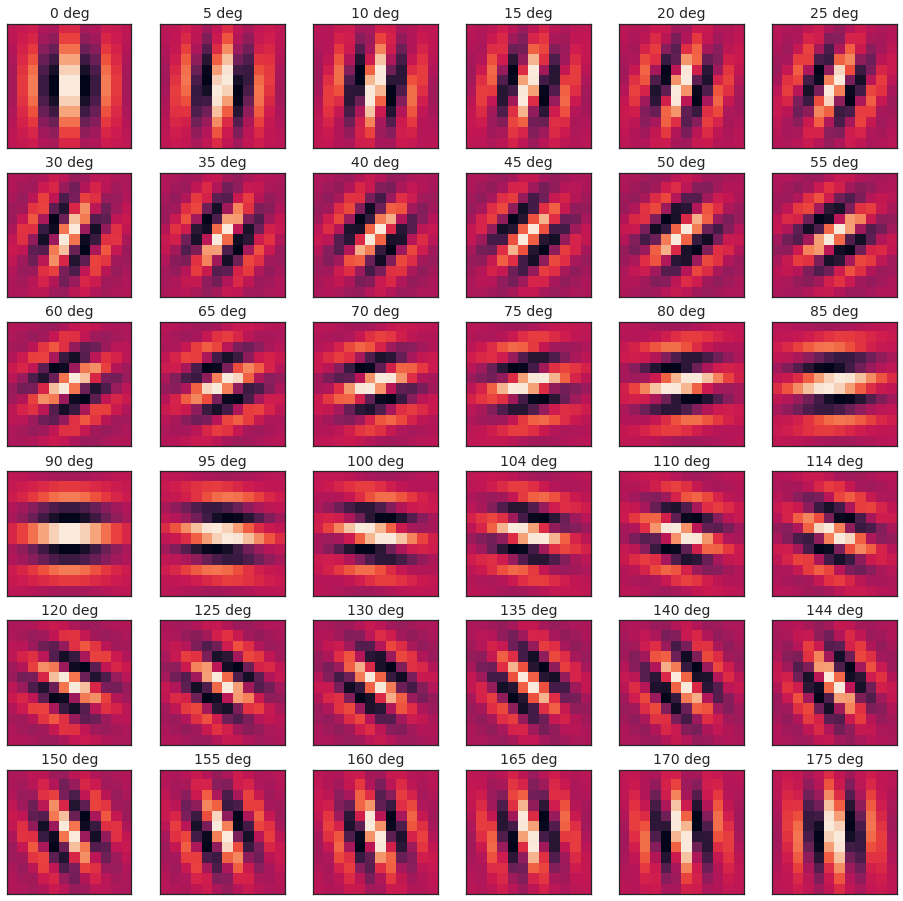

In [34]:
## Visualize the orientation filters (also double check the labels for degrees here)
# Note these are complex numbers, showing real parts only here. If you plot imaginary, will be 90 deg out of phase.

plt.figure(figsize=(16,16));
for ff in range(36):
    
    plt.subplot(6,6,ff+1)
    plt.imshow(np.real(np.squeeze(orient_filters[ff,0,:,:])))
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title('%d deg'%orients_deg[ff])

In [35]:
# pass data through Gaborizer and get out tensor for each feature map.
n_images=20
_x = torch.tensor(val_stim_multi_trial_data[0:n_images]).to(device) # the input variable.
_fmaps = _fmaps_fn(_x)

resolutions_each_sf = []
for k,_fm in enumerate(_fmaps):
    print (_fm.size())
    resolutions_each_sf.append(_fm.size()[2])

/home/mmhender/myenv/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([20, 36, 13, 13])
torch.Size([20, 36, 18, 18])
torch.Size([20, 36, 23, 23])
torch.Size([20, 36, 30, 30])
torch.Size([20, 36, 40, 40])
torch.Size([20, 36, 54, 54])
torch.Size([20, 36, 71, 71])
torch.Size([20, 36, 95, 95])
torch.Size([20, 36, 126, 126])
torch.Size([20, 36, 168, 168])
torch.Size([20, 36, 224, 224])
torch.Size([20, 36, 298, 298])


In [36]:
# Now converting from stacks of feature maps to big feature matrix [nImages x nOri*nSF]
# To do this need a candidate pRF. 
# Using one that was fit for an example voxel here. 

vidx = np.argsort(val_cc)[-1]
x = best_params[0][vidx,0]
y = best_params[0][vidx,1]
sigma = best_params[0][vidx,2]
dtype=fpX

# will compute activation in each feature channel for this voxel's best RF (from trn data)
actinprf = np.zeros([n_images,n_ori*n_sf])
# also computing mean activation across image, just for comparison.
meanact = np.zeros([n_images,n_ori*n_sf])

orilist_feat = np.zeros([n_ori*n_sf,1])
sflist_feat = np.zeros([n_ori*n_sf,1])
feat_ind = -1
for sf in range(n_sf):
        
    fmap = _fmaps[sf].cpu().detach().numpy()
    n_pix = np.shape(fmap)[2]
    prf = pnu.make_gaussian_mass(x, y, sigma, n_pix, size=aperture, dtype=dtype)[2]

    for oo in range(n_ori):

        feat_ind=feat_ind+1
        orilist_feat[feat_ind] = oo
        sflist_feat[feat_ind]= sf
        
        for ii in range(n_images):
        
            act = np.sum(np.sum(fmap[ii,oo,:,:]*prf)) 
            actinprf[ii,feat_ind] = act
            meanact[ii,feat_ind] = np.mean(np.mean(fmap[ii,oo,:,:]))

# make sure this order matches features from original encoding model calculations
assert(np.all(np.squeeze(orilist_feat==1)==ori_tuning_masks[1]))

# Now taking the average over spatial frequency channels, want a single value for each orientation each image
actinprf_reshaped = np.reshape(actinprf, [n_images, n_ori, n_sf], order='F')
mean_orient_actinprf = np.mean(actinprf_reshaped, axis=2)
print(np.shape(mean_orient_actinprf))


(20, 36)


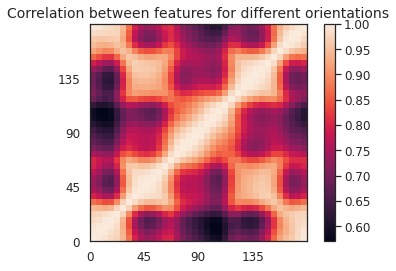

In [38]:
# Correlation structure among the features (orients at one spatial frequency only)
# Computed over validation set images. 
# For just a few images at a specific location, this can have some irregularities...

# sf2use = 4
# features2use = meanact[:,np.squeeze(sflist_feat==sf2use)]
# features2use = actinprf[:,sf_tuning_masks[sf2use]]
features2use = mean_orient_actinprf
correlation_matrix = np.corrcoef(np.transpose(features2use))
plt.figure();
plt.pcolormesh(correlation_matrix)
plt.axis('square')
plt.xticks(np.arange(0,36,9), labels= np.arange(0,179,45))
plt.yticks(np.arange(0,36,9), labels= np.arange(0,179,45))
plt.title('Correlation between features for different orientations')
plt.colorbar()

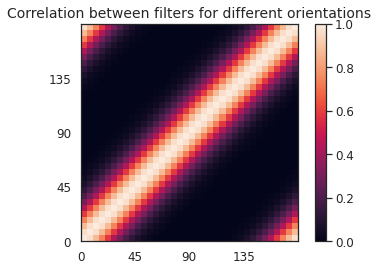

In [39]:
# Correlation structure among the filters themselves

features2use = np.reshape(np.real(orient_filters),[n_ori,np.prod(np.shape(orient_filters)[2:4])],order='F')

correlation_matrix = np.corrcoef(features2use)
plt.figure();
plt.pcolormesh(correlation_matrix)
plt.axis('square')
plt.xticks(np.arange(0,36,9), labels= np.arange(0,179,45))
plt.yticks(np.arange(0,36,9), labels= np.arange(0,179,45))
plt.title('Correlation between filters for different orientations')
plt.colorbar()

[0.57612557 0.54444135 0.49823541 0.49193276 0.5545902  0.67832663
 0.77255351 0.81119581 0.81752324 0.82519542 0.82457478 0.80258029
 0.74554863 0.62426549 0.49158279 0.42245906 0.4159059  0.42866632
 0.43425686 0.42983854 0.41939411 0.43940727 0.52025234 0.65839329
 0.76503448 0.80890083 0.82826958 0.83755506 0.83046209 0.812006
 0.77053172 0.6804958  0.57799373 0.52203943 0.531016   0.56919342]


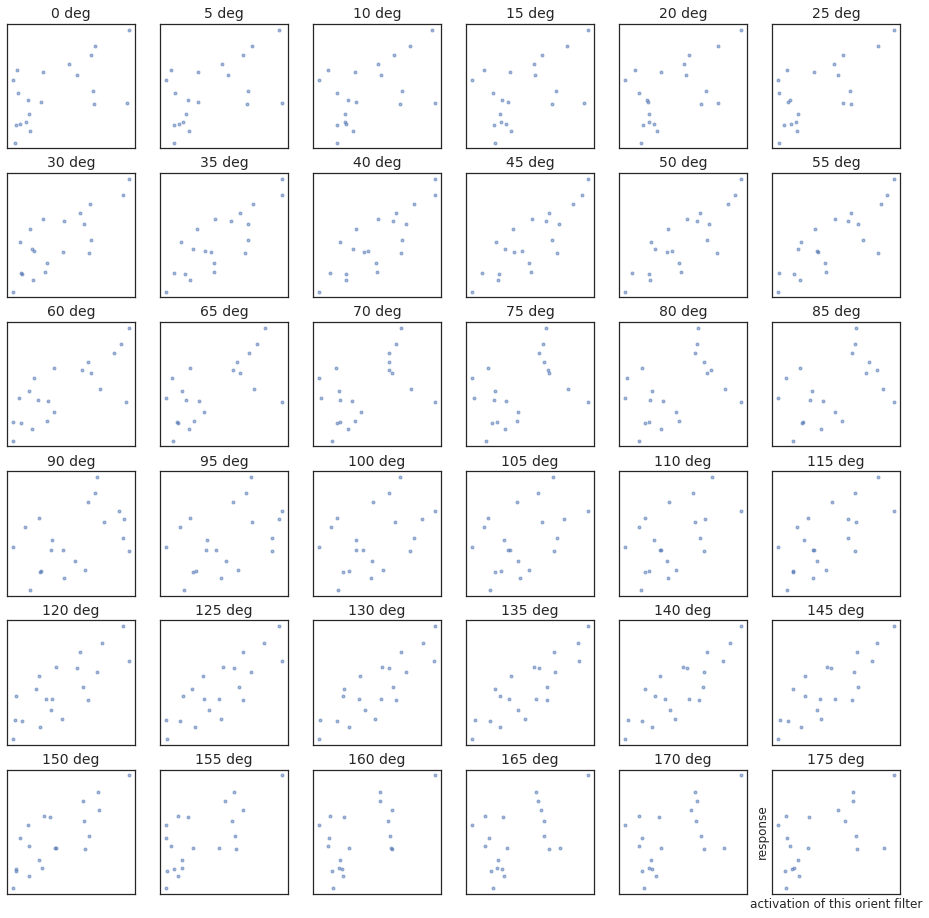

In [40]:
# Now want to measure how the voxel responded to trials with a given orientation content.
# for each orient channel, going to plot voxel's response versus activation in that channel.

dat2plot = val_voxel_multi_trial_data[0:n_images,vidx]

# taking out just orientations at the SF which had highest weight
# features2use = actinprf[:,sf_tuning_masks[best_sf]]
features2use = mean_orient_actinprf

np.shape(features2use)
# estimating the "best" orientation for each trial
max_ori_each_trial = orients_deg[np.argmax(features2use,axis=1)]

resp_corrs = np.zeros((n_ori,))
plt.figure(figsize=(16,16));
for oo in range(n_ori):
    plt.subplot(6,6,oo+1)
    plt.plot(features2use[:,oo], dat2plot,'.',alpha=0.5)
    resp_corrs[oo] = np.corrcoef(features2use[:,oo], dat2plot)[0,1]
    plt.title('%d deg'%np.round(orients_deg[oo],1))
    plt.xticks([]); plt.yticks([])
    if oo==n_ori-1:
        plt.xlabel('activation of this orient filter')
        plt.ylabel('response')
        
print(resp_corrs)

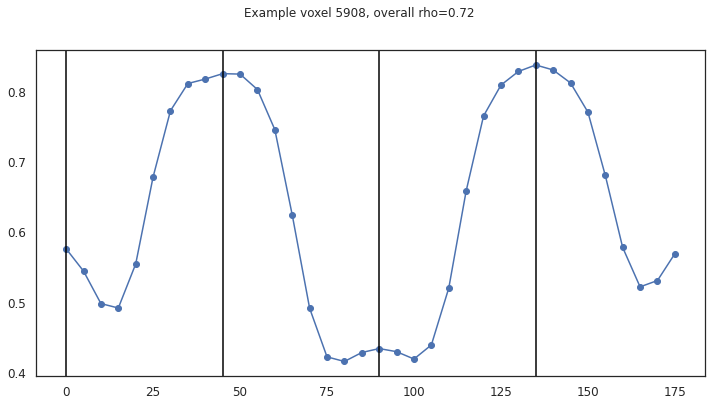

In [47]:
# Correlation coefficient between filter activation and voxel response, as a function of filter orientation

plt.figure(figsize=(12,6));
plt.plot(orients_deg, resp_corrs,'-o')
for oo in np.arange(0,179,45):
    plt.axvline(oo,color='k')
plt.suptitle('Example voxel %d, overall rho=%.2f'%(vidx, val_cc[vidx]));

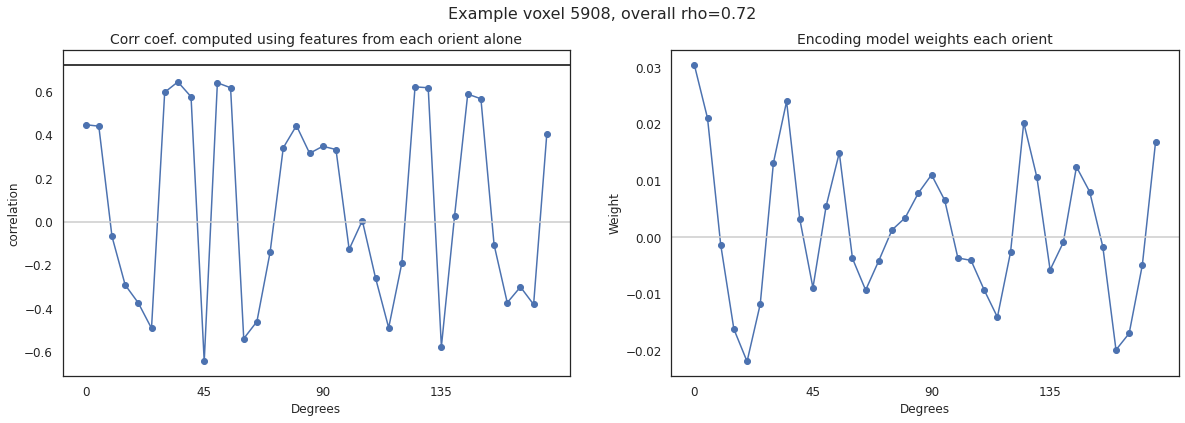

In [42]:
# for comparison, plotting the other ways of measuring "tuning"

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(orients_deg, partition_cc_ori[:,vidx],'-o')
plt.xlabel('Degrees')
plt.ylabel('correlation')
plt.title('Corr coef. computed using features from each orient alone')
plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))

plt.subplot(1,2,2)
# plt.plot(orients_deg, allw_reshaped[vidx,4,:])
plt.plot(orients_deg, mean_orient_weights[vidx,:],'-o')
plt.xlabel('Degrees')
plt.ylabel('Weight')
plt.title('Encoding model weights each orient')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))

plt.suptitle('Example voxel %d, overall rho=%.2f'%(vidx, val_cc[vidx]),fontsize=16);

plotting orient 150 deg
plotting orient 155 deg
0.9934749077919532
plotting orient 150 deg
plotting orient 165 deg
0.9730147900728923


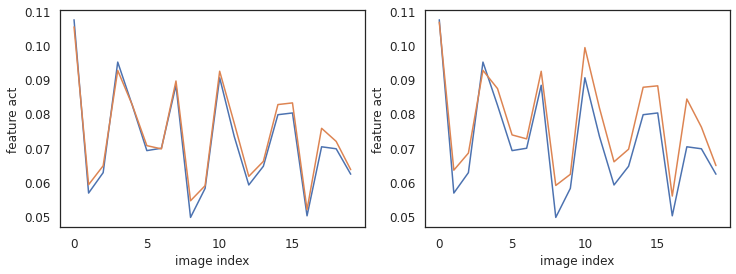

In [43]:
# plotting some more things abt correlations

plt.figure(figsize=(12,4))
sf2use=4
features2use = meanact[:,np.squeeze(sflist_feat==sf2use)]

plt.subplot(1,2,1)
for oo in (30,31):
    plt.plot(features2use[:,oo])
    print('plotting orient %d deg'%orients_deg[oo])
plt.xlabel('image index')
plt.ylabel('feature act')
# plt.ylim([0.002, 0.02])
print(np.corrcoef(features2use[:,30], features2use[:,31])[0,1])

plt.subplot(1,2,2)
for oo in (30,33):
    plt.plot(features2use[:,oo])
    print('plotting orient %d deg'%orients_deg[oo])
plt.xlabel('image index')
plt.ylabel('feature act')
# plt.ylim([0.002, 0.02])
print(np.corrcoef(features2use[:,30], features2use[:,33])[0,1])

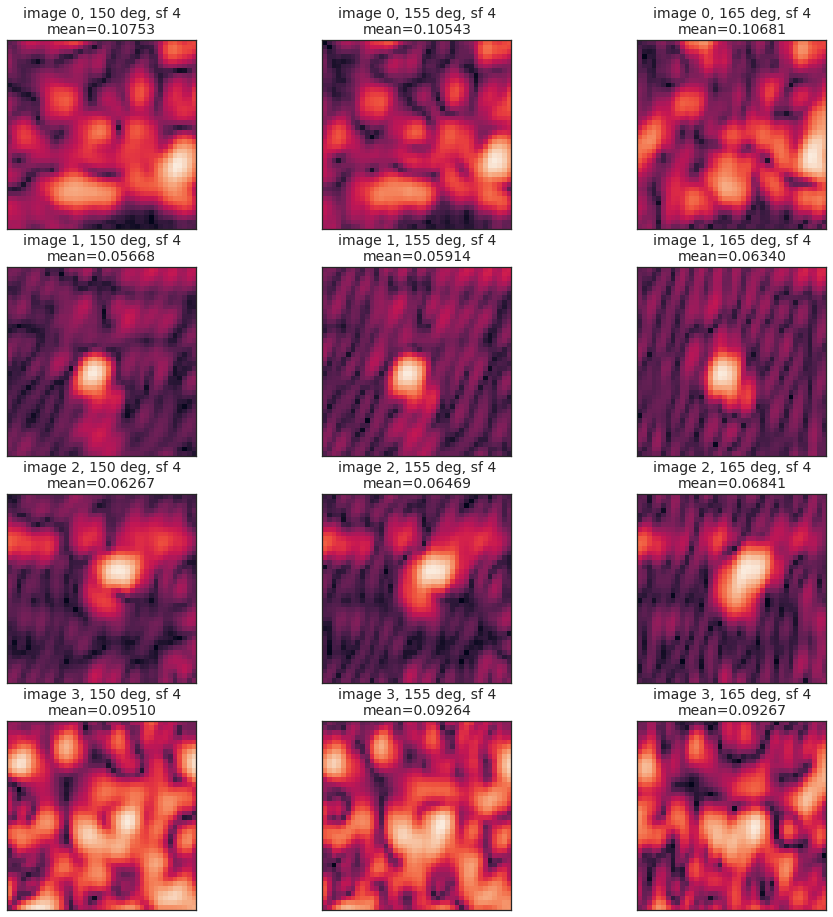

In [44]:
# plotting some more things abt correlations
sf=4
fmap = _fmaps[sf].cpu().detach().numpy()
ori2plot = [30,31,33]
plt.figure(figsize=(16,16))
for ii in range(4):
    
    plt.subplot(4,3,3*ii+1)
    plt.pcolormesh(fmap[ii,ori2plot[0],:,:])
    plt.axis('square')
    plt.title('image %d, %d deg, sf %d\nmean=%.5f'%(ii, orients_deg[ori2plot[0]], sf, np.mean(np.mean(fmap[ii,ori2plot[0],:,:]))))
    plt.xticks([]); plt.yticks([])
    
    plt.subplot(4,3,3*ii+2)
    plt.pcolormesh(fmap[ii,ori2plot[1],:,:])
    plt.axis('square')
    plt.title('image %d, %d deg, sf %d\nmean=%.5f'%(ii, orients_deg[ori2plot[1]], sf, np.mean(np.mean(fmap[ii,ori2plot[1],:,:]))))
    plt.xticks([]); plt.yticks([])
    
    plt.subplot(4,3,3*ii+3)
    plt.pcolormesh(fmap[ii,ori2plot[2],:,:])
    plt.axis('square')
    plt.title('image %d, %d deg, sf %d\nmean=%.5f'%(ii, orients_deg[ori2plot[2]], sf, np.mean(np.mean(fmap[ii,ori2plot[2],:,:]))))
    plt.xticks([]); plt.yticks([])

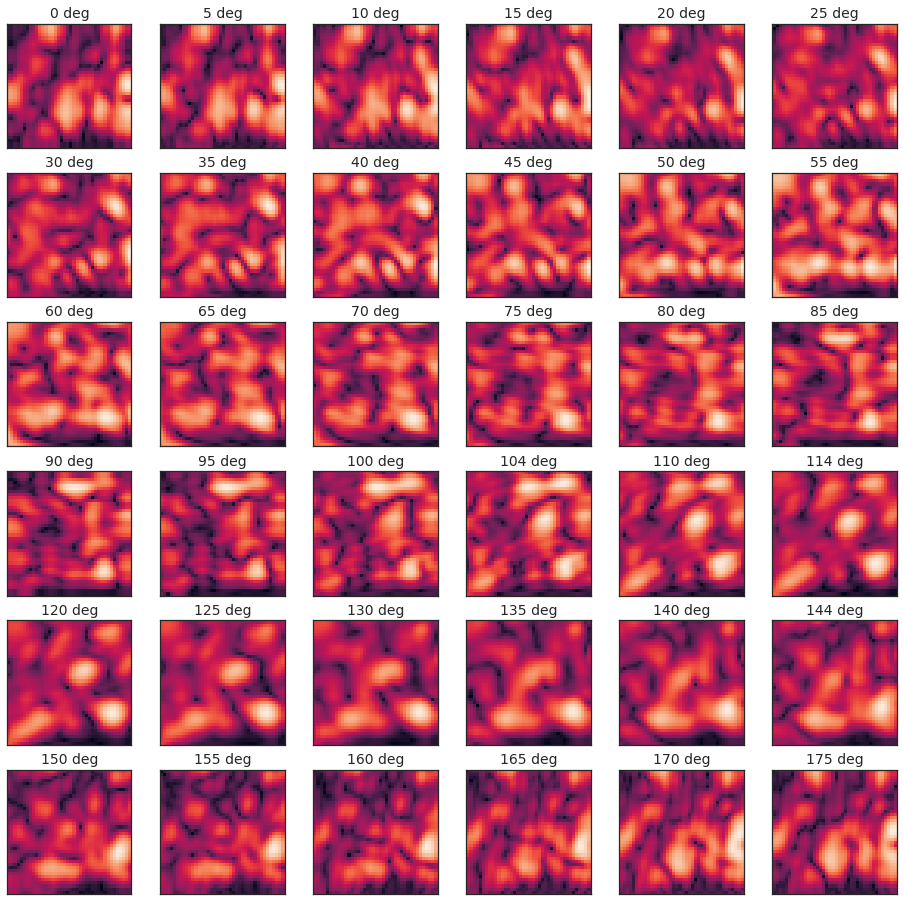

In [46]:
# plotting some more things abt correlations
sf = 4
ii = 0
plt.figure(figsize=(16,16));

fmap = _fmaps[sf].cpu().detach().numpy()

# n_pix = resolutions_each_sf[sf]
# dtype=fpX

# x=0
# y=0
# sigma=0.3
# prf = pnu.make_gaussian_mass(x, y, sigma, n_pix, size=aperture, dtype=dtype)[2]

for oo in range(36):  
       

    plt.subplot(6,6,oo+1)
    plt.pcolormesh(fmap[ii,oo,:,:])
    plt.axis('square')
    plt.title('%d deg'%(orients_deg[oo]))
    plt.xticks([]); plt.yticks([])
    